# CodRNA

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/cod-rna(59535,8).txt')
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/cod-rna_test(271617,8).txt')
x_test, y_test = shuffle(x_test, y_test, random_state=241)
x_test = x_test[:1e4]
y_test = y_test[:1e4]

data_name = 'cod-rna'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape

print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 59535
of features: 8
cod-rna


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## K-Means cluster centers

In [3]:
ind_num = 400
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=1, max_iter=10, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [4]:
with open('../plots/vi_vs_svi_class/'+ data_name +'_title.txt', 'w') as f:
    title = data_name + ' dataset, ' + 'n = ' + str(num) + ', d = ' + str(dim) + ', m = ' + str(ind_num)
    f.write(title)

In [5]:
cov_params = np.array([4., 2., .5])

## SVM
Here we train an SVM for reference

In [25]:
svm = SVC(C=1e2)
svm.fit(x_tr.T, y_tr)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/svm/base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [26]:
predicted = svm.predict(x_test.T)
accuracy_score(y_test, predicted)

0.9657

## svi-L-BFGS-B-c method

In [7]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [8]:
opts = {'mode': 'full', 'maxiter': 60, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 4.   2.   0.5  0.   0. ]
Hyper-parameters at iteration 1 : [ 3.99794946  2.5128914   0.49974818 -0.05528539  0.04620212]
Hyper-parameters at iteration 2 : [ 4.05570678  3.13629751  0.33711133 -0.17588693  0.14848544]
Hyper-parameters at iteration 3 : [ 4.22636909  5.75629333  0.249456   -0.61754213  0.5219927 ]
Hyper-parameters at iteration 4 : [  4.55282713  11.53224056   0.54860709  -1.54047939   1.3011188 ]
Hyper-parameters at iteration 5 : [  4.75841787  14.07048355   0.49744749  -1.98370006   1.67543732]
Hyper-parameters at iteration 6 : [  5.38437464  19.46623605   0.35071089  -2.94230193   2.48348037]
Hyper-parameters at iteration 7 : [  5.45800511  20.30255339   0.41472547  -3.07856524   2.59808072]
Hyper-parameters at iteration 8 : [  5.70124757  22.54761774   0.46023644  -3.46526133   2.92369043]
Hyper-parameters at iteration 9 : [  6.00295206  24.32626517   0.49241449  -3.78243086   3.18996551]
Hyper-parameters at iteration 10 : [  6.82959

In [9]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

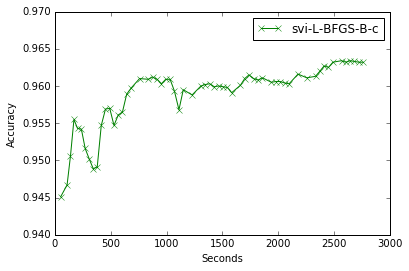

In [10]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.94, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [11]:
svi_y_lst[-1]

0.96320000000000006

## vi-means-c method

In [12]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=10)

Hyper-parameters at iteration 0 : [ 4.   2.   0.5]
Hyper-parameters at iteration 1 : [ 4.0199986   2.14897526  0.49932556]
Hyper-parameters at iteration 2 : [ 4.01663511  1.90350038  0.01      ]
	Hyper-parameters at outter iteration 0 : [ 4.01537346  1.87229465  0.01      ]
Hyper-parameters at iteration 0 : [ 4.01537346  1.87229465  0.01      ]
Hyper-parameters at iteration 1 : [ 9.84006938  1.8078366   0.01      ]
	Hyper-parameters at outter iteration 1 : [  1.00216119e+01   2.01481274e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.00216119e+01   2.01481274e+00   1.00000000e-02]
Hyper-parameters at iteration 1 : [  1.00221735e+01   2.01455554e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 2 : [  1.00224941e+01   2.01442122e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.00224941e+01   2.01442122e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 3 : [  1.00240530e+01   2.15060396e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [

Processing parameter number1/11
Processing parameter number2/11
Processing parameter number3/11
Processing parameter number4/11
Processing parameter number5/11
Processing parameter number6/11
Processing parameter number7/11
Processing parameter number8/11
Processing parameter number9/11
Processing parameter number10/11
Processing parameter number11/11


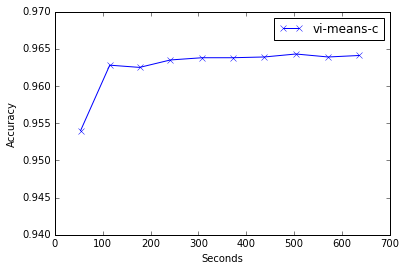

In [13]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1, verbose=True)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.94, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [14]:
vi_y_lst[-1]

0.96409999999999996

### Taylor
Подбор числа пересчетов

In [15]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

Hyper-parameters at iteration 0 : [ 4.   2.   0.5]
	Hyper-parameters at outter iteration 0 : [ 3.99050632  3.52915557  0.49883411]
Hyper-parameters at iteration 0 : [ 3.99050632  3.52915557  0.49883411]
Hyper-parameters at iteration 1 : [ 20.56994931   2.92379077   0.41474491]
Hyper-parameters at iteration 2 : [  2.19519679e+01   4.23313835e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  5.65592463e+01   1.22590339e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  5.65592463e+01   1.22590339e+01   1.00000000e-02]
Hyper-parameters at iteration 1 : [ 56.56107896  12.25513824   0.32803385]
	Hyper-parameters at outter iteration 2 : [ 56.56064247  12.25418529   0.20112031]
Hyper-parameters at iteration 0 : [ 56.56064247  12.25418529   0.20112031]
	Hyper-parameters at outter iteration 3 : [ 56.5645912   12.46160075   0.20098982]
Hyper-parameters at iteration 0 : [ 56.5645912   12.46160075   0.20098982]
	Hyper-parameters at outter iteration 4 : [ 56.56500047  12.46

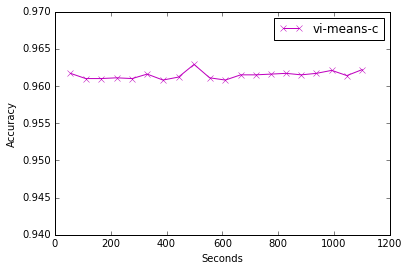

In [16]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_t_x_lst, vi_t_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.94, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [17]:
vi_t_y_lst[-1]

0.96219999999999994

### JJ-full
#### Standard

In [6]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'maxiter':10, 'mydisp': True, 'hybrid': False}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Standard mode
Hyper-parameters at iteration 0 : [ 4.   2.   0.5  1.   1. ]
Hyper-parameters at iteration 1 : [ 3.98824554  2.26603878  0.49820234  1.00006573  1.0001529 ]
Hyper-parameters at iteration 2 : [ 4.01113459  1.79078803  0.30264296  0.99995065  0.99988615]
Hyper-parameters at iteration 3 : [ 4.03054797  1.52143845  0.01        0.9998905   0.99974561]
Hyper-parameters at iteration 4 : [ 4.03382031  1.67403888  0.01        0.99993035  0.99984212]
Hyper-parameters at iteration 5 : [ 4.03492808  1.67368138  0.01        0.99993063  0.99984295]
Hyper-parameters at iteration 6 : [ 4.18945236  1.66606571  0.01        0.99998002  0.99998401]
Hyper-parameters at iteration 7 : [ 4.60054202  1.65385585  0.01        1.00011406  1.00036591]
Hyper-parameters at iteration 8 : [ 5.15122724  1.69430748  0.01        1.00031083  1.00092047]
Hyper-parameters at iteration 9 : [ 9.47155755  2.09896503  0.01        1.00188072  1.00533655]
Hyper-parameters at iteration 10 : [ 9.25156705  2.07467708  

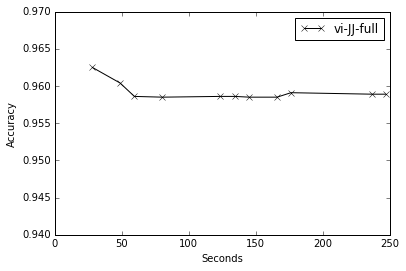

In [7]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_full_x_lst, vi_full_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.94, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

#### Hybrid

In [8]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'mydisp': True, 'hybrid': True, 'maxfun':5, 'maxoutiter': 3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hybrid mode
	Analytic updates number:3
Hyper-parameters at iteration 0 : [ 4.   2.   0.5  1.   1. ]
Hyper-parameters at iteration 1 : [ 3.98824554  2.26603878  0.49820234  1.00006573  1.0001529 ]
Hyper-parameters at iteration 2 : [ 4.01113459  1.79078803  0.30264296  0.99995065  0.99988615]
Hyper-parameters at iteration 3 : [ 4.03054797  1.52143845  0.01        0.9998905   0.99974561]
Hyper-parameters at iteration 0 : [ 4.03882694  1.90751533  0.01        2.03605681  2.31431281]
Hyper-parameters at iteration 1 : [ 5.03550068  1.88766579  0.01        2.03624922  2.31453998]
Hyper-parameters at iteration 2 : [ 5.68576256  1.86011904  0.01        2.03639042  2.3147019 ]
Hyper-parameters at iteration 3 : [ 6.11028572  1.87367757  0.01        2.0364848   2.3148095 ]
Hyper-parameters at iteration 0 : [ 7.4948843   1.94603642  0.01        2.65108396  2.89613317]
Hyper-parameters at iteration 1 : [ 7.80427863  1.90565833  0.01        2.65133062  2.89636697]


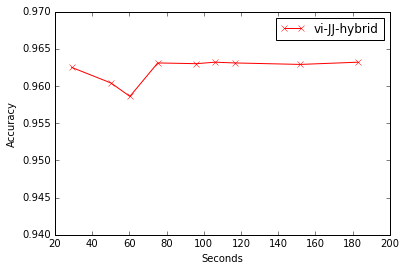

In [9]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_h_x_lst, vi_h_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.ylim([0.94, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подбор длины шага

In [6]:
results = []
steps = [1.2, 1.1, 1., .9, .8, .7, .6, .5]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 7, 'verbose': True, 'batch_size': 500, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

1.2
Using AdaDelta optimizer
Iteration  0 :
	Gradient norm 37.6137491804
Iteration  1 :
	Gradient norm 6.32709014152
Iteration  2 :
	Gradient norm 60.3226481758
Iteration  3 :
	Gradient norm 42.8334453296
Iteration  4 :
	Gradient norm 12.8336539456
Iteration  5 :
	Gradient norm 46.1527368433
Iteration  6 :
	Gradient norm 23.1028517943
1.1
Using AdaDelta optimizer
Iteration  0 :
	Gradient norm 71.3572115589
Iteration  1 :
	Gradient norm 109.713541485
Iteration  2 :
	Gradient norm 17.0223524106
Iteration  3 :
	Gradient norm 143.789343845
Iteration  4 :
	Gradient norm 16.5367017543
Iteration  5 :
	Gradient norm 14.5658030495
Iteration  6 :
	Gradient norm 10.6426346299
1.0
Using AdaDelta optimizer
Iteration  0 :
	Gradient norm 24.5586599529
Iteration  1 :
	Gradient norm 52.059380602
Iteration  2 :
	Gradient norm 85.1658441521
Iteration  3 :
	Gradient norm 38.259313095
Iteration  4 :
	Gradient norm 33.2581326026
Iteration  5 :
	Gradient norm 25.9294846534
Iteration  6 :
	Gradient norm 28.40

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4
5
6
7


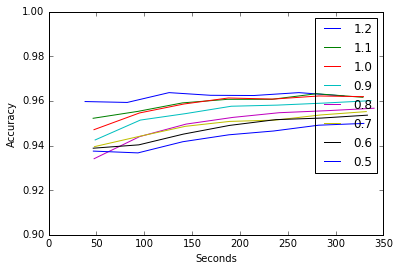

In [8]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [12]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 40, 'verbose': True, 'batch_size': 500, 
        'step_rate': 1., 'print_freq':10}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Using AdaDelta optimizer
Iteration  9 :
	Gradient norm 24.6264275801
Iteration  19 :
	Gradient norm 7.99485573635
Iteration  29 :
	Gradient norm 40.7951178436
Iteration  39 :
	Gradient norm 18.2651163724


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


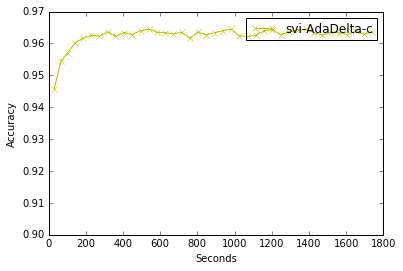

In [13]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([.9, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [11]:
svi_ad_y_lst[-1]

0.93140000000000001

In [19]:
max(vi_t_x_lst)

1101.1368098258972

## Выводы

In [10]:
svi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy')
svi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy')
svi_ad_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy')
svi_ad_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy')
vi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy')
vi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy')
vi_t_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy')
vi_t_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy')

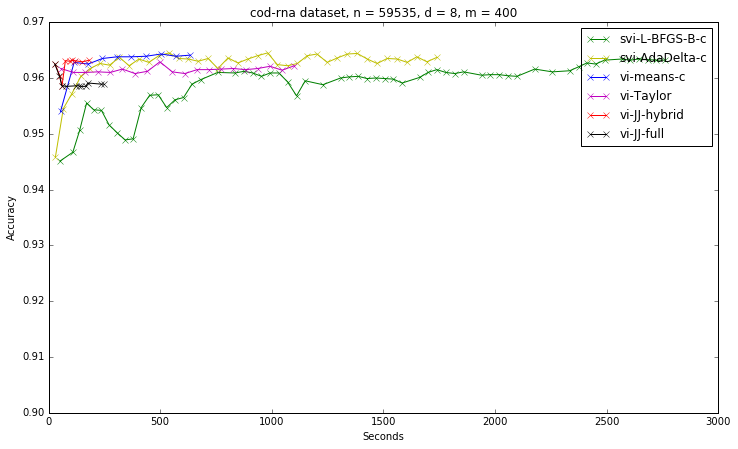

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.9, .97])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')
plt.title(data_name+' dataset, n = ' + str(num) + ', d = ' + str(dim) + ', m = '+ str(ind_num))

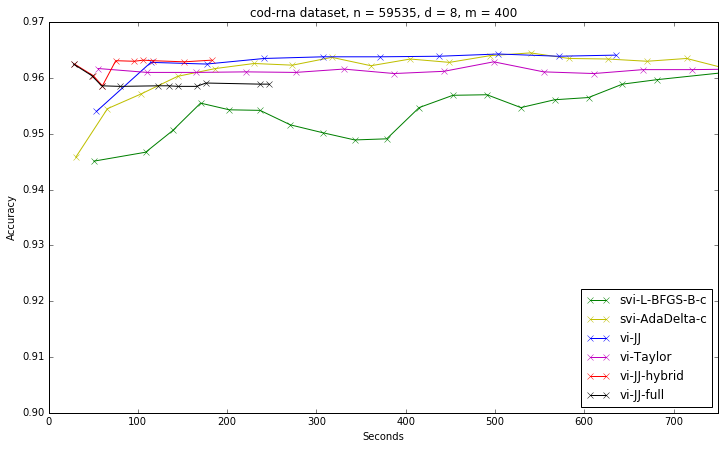

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-JJ')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.plot(vi_h_x_lst[1:], vi_h_y_lst[1:], '-rx', label='vi-JJ-hybrid')
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
plt.ylim([0.9, .97])
plt.xlim([0., 750])
plt.legend(loc=4)
plt.xlabel('Seconds')
plt.ylabel('Accuracy')
plt.title(data_name+' dataset, n = ' + str(num) + ', d = ' + str(dim) + ', m = '+ str(ind_num))

In [23]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'/svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/ad_y.npy', svi_ad_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_t_x.npy', vi_t_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_t_y.npy', vi_t_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_h_x.npy', vi_h_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_h_y.npy', vi_h_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_f_x.npy', vi_full_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'/vi_f_y.npy', vi_full_y_lst)